## Physical implementation of a qubit device

In [1]:
%matplotlib inline
import numpy as np

from qutip import *
from qutip.qip.device import *
from qutip.qip.operations import rx, gate_sequence_product
from qutip.qip.circuit import QubitCircuit
from qutip.qip.circuit_latex import _latex_compile

%load_ext autoreload
%autoreload 2

### Circuit Setup

In [2]:
# Number of qubits in the system
N = 2

# Input state
input_states = ["0"]*N

# A list of integers for the dimension of each composite system.
dims = [2]*N

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)

qc.add_gate("RX", 0, None, -np.pi/2, r"-\pi/2")

In [3]:
U_ideal = gate_sequence_product(qc.propagators())

U_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        +0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.j
  0.        +0.70710678j]
 [0.        +0.70710678j 0.        +0.j         0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.        +0.j
  0.70710678+0.j        ]]

### Processor
A simulator of a quantum device based on the QuTiP solver
:func:`qutip.mesolve`.
It is defined by the available driving Hamiltonian and
the decoherence time for each component systems.
The processor can simulate the evolution under the given
control pulses. Noisy evolution is supported by
:class:`qutip.qip.Noise` and can be added to the processor.

In [4]:
p1 = CircularSpinChain(N, correct_global_phase=True)

U_list = p1.run(qc)

U_physical = gate_sequence_product(U_list)

U_physical.tidyup(atol=1e-5)

asd
[1.5707963267948966, 1.5707963267948966]
[0.6283185307179586, 0.6283185307179586]
[<qutip.qip.pulse.Pulse object at 0x7fdf0883a610>, <qutip.qip.pulse.Pulse object at 0x7fdf4810dfd0>, <qutip.qip.pulse.Pulse object at 0x7fdf4810d1f0>, <qutip.qip.pulse.Pulse object at 0x7fdf310dd040>, <qutip.qip.pulse.Pulse object at 0x7fdf310dd250>]
[0.  0.5]
[array([-1.57079633]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        +0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.j
  0.        +0.70710678j]
 [0.        +0.70710678j 0.        +0.j         0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.        +0.j
  0.70710678+0.j        ]]

In [5]:
p1.qc0.gates

[Gate(RX, targets=[0], controls=None)]

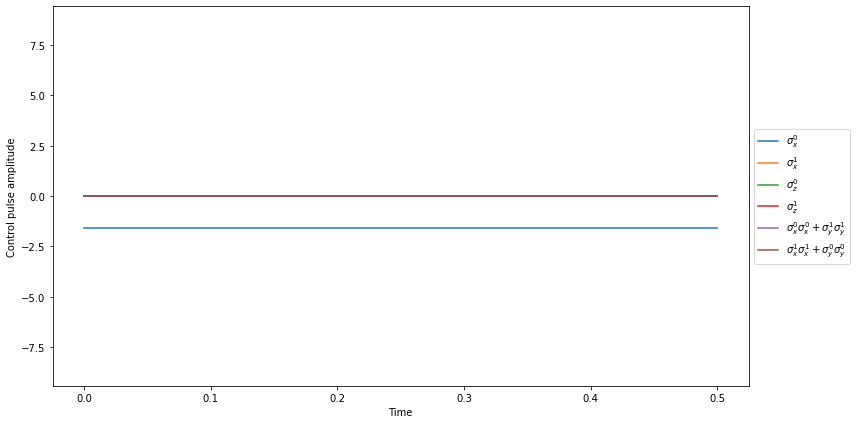

In [6]:
p1.plot_pulses();

In [7]:
p1.load_circuit(qc);

[0.  0.5]
[array([-1.57079633]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]


35.866872175650876


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3905e46d0>)

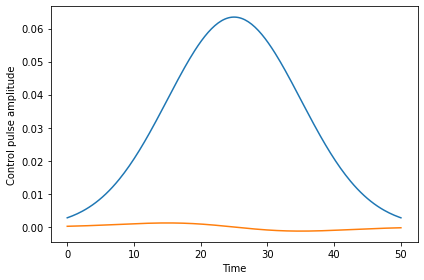

In [54]:
# energy levels
N = 3 # Qutrit

# Annihilation operator for the transmon
a = destroy(N)

# Qubit frequency (0->1) in GHz
omega = 2*np.pi * 5.708390

# Drive frequency in MHz
omega_drive = omega

# Self-Kerr coefficient (anharmonicity) in GHz
alpha = - 2*np.pi* 0.261081457

# Set rotating frame frequency (should be close to qubit frequencies for fast simulations)
rotating_frame = omega #2*np.pi*5.0
print(rotating_frame)

# Transmon Hamiltonian in rotating frame
H_qubit = (omega-rotating_frame) * a.dag() * a + alpha / 2 * pow(a.dag(),2) * pow(a,2)

# Drive Hamiltonian (since we have drag pulses, we need both x and y drive)
H_drive_x = a.dag() + a
H_drive_y = 1j*(a.dag() - a)

# Gaussian width in ns
sigma = 10

# Gate time in ns
L = 50

def H_drive_coeff_x(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = q * (t-0.5*L) / sigma * E # dE/dt
    return I*np.cos(drive_freq * t) + Q*np.sin(drive_freq * t)

def H_drive_coeff_y(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = -q * (t-0.5*L) / sigma * E # dE/dt
    return Q*np.cos(drive_freq * t) + I*np.sin(drive_freq * t)

t_total = L
tlist = np.linspace(0,t_total,100)

amp = 0.06345380720748712
args = {'amp': amp, 'qscale': 0.032, 'freq': (rotating_frame - omega_drive)}

p = Processor(N=1, dims = [3], spline_kind="cubic")

p.add_control(H_drive_x,targets=0)
p.add_control(H_drive_y,targets=0)
p.add_drift(H_qubit,targets=0)

I = H_drive_coeff_x(tlist,args)
Q = H_drive_coeff_y(tlist,args)
p.pulses[0].tlist = np.array(tlist)
p.pulses[0].coeff = np.array(I)
p.pulses[1].tlist = np.array(tlist)
p.pulses[1].coeff = np.array(Q)

p.plot_pulses()

In [68]:
H_qubit

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -1.64042317]]

In [64]:
result = p.run_state(init_state=basis(3,0),analytical=False)

In [66]:
fidelity(result.states[-1])

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 6.90470113e-04+8.09890685e-05j]
 [-4.34457158e-02-9.99052695e-01j]
 [ 7.16177273e-05-2.38633000e-03j]]

In [35]:
import qutip.ipynbtools
qutip.ipynbtools.version_table()

Software,Version
QuTiP,4.5.0.dev0+01132789
Numpy,1.18.1
SciPy,1.4.1
matplotlib,3.2.1
Cython,0.29.16
Number of CPUs,6
BLAS Info,Generic
IPython,7.13.0
Python,"3.8.2 | packaged by conda-forge | (default, Mar 23 2020, 17:55:48) [Clang 9.0.1 ]"
OS,posix [darwin]


In [80]:
# energy levels
N = 3 # Qutrit

# Annihilation operator for the transmon
a = destroy(N)

# Qubit frequency (0->1) in GHz
omega = 2*np.pi * 5.708390

# Drive frequency in MHz
omega_drive = omega

# Self-Kerr coefficient (anharmonicity) in GHz
alpha = - 2*np.pi* 0.261081457

# Set rotating frame frequency (should be close to qubit frequencies for fast simulations)
rotating_frame = omega #2*np.pi*5.0

# Annihilation operators for the two qutrits
a2 = tensor(qeye(N), destroy(N))
a1 = tensor(destroy(N), qeye(N))

# Transmon Hamiltonian in rotating frame
H_qubit = (omega-rotating_frame) * a1.dag() * a1 + alpha / 2 * pow(a1.dag(),2) * pow(a1,2) + \
          (omega-rotating_frame) * a2.dag() * a2 + alpha / 2 * pow(a2.dag(),2) * pow(a2,2)

# Drive Hamiltonian (since we have drag pulses, we need both x and y drive)
H_drive_x = a.dag() + a
H_drive_y = 1j*(a.dag() - a)

# Gaussian width in ns
sigma = 10

# Gate time in ns
L = 50

def H_drive_coeff_x(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = q * (t-0.5*L) / sigma * E # dE/dt
    return I*np.cos(drive_freq * t) + Q*np.sin(drive_freq * t)

def H_drive_coeff_y(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = -q * (t-0.5*L) / sigma * E # dE/dt
    return Q*np.cos(drive_freq * t) + I*np.sin(drive_freq * t)

t_total = L
tlist = np.linspace(0,t_total,100)

amp = 0.06345380720748712
args = {'amp': amp, 'qscale': 0.032, 'freq': (rotating_frame - omega_drive)}

In [82]:
H_qubit

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -1.64042317  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.64042317
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.64042317  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -1.64042317  0.        ]
 [ 0.          0.          0.          0.          0.   

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd370278c70>)

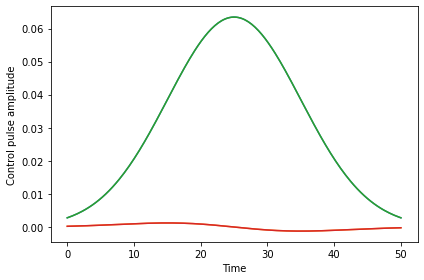

In [91]:
p = Processor(N = 2, dims = [3]*N, spline_kind="cubic")

p.add_control(H_drive_x, cyclic_permutation = True)
p.add_control(H_drive_y, cyclic_permutation = True)

p.add_drift(H_qubit, targets = [0,1])

I = H_drive_coeff_x(tlist,args)
Q = H_drive_coeff_y(tlist,args)

p.pulses[0].tlist = np.array(tlist)
p.pulses[0].coeff = np.array(I)
p.pulses[1].tlist = np.array(tlist)
p.pulses[1].coeff = np.array(Q)
p.pulses[2].tlist = np.array(tlist)
p.pulses[2].coeff = np.array(I)
p.pulses[3].tlist = np.array(tlist)
p.pulses[3].coeff = np.array(Q)

p.plot_pulses()

In [92]:
psi = tensor(basis(3,0),basis(3,0))
result = p.run_state(init_state=psi,analytical=False)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_get_qobjevo_helper', 'coeff', 'get_qobj', 'get_qobjevo', 'qobj', 'targets', 'tlist']
{'qobj': Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -1.64042317  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         

ValueError: operands could not be broadcast together with shapes (27,) (9,) 

In [89]:
result[-1]

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = False
Qobj data =
[[ 9.99998704e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.25063182e-04+1.25063182e-04j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+2.21194595e-08j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.25063182e-04-1.59552255e-03j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   2.15182205e-07-1.83900566e-07j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.52921423e-11+2.76633358e-12j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.78901997e-06-2.82194314e-07j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.88448656e-10-2.59032985e-10j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [